Worst case drop across portfolio is: 18.32 % at 95% confidence


<AxesSubplot:xlabel='Date'>

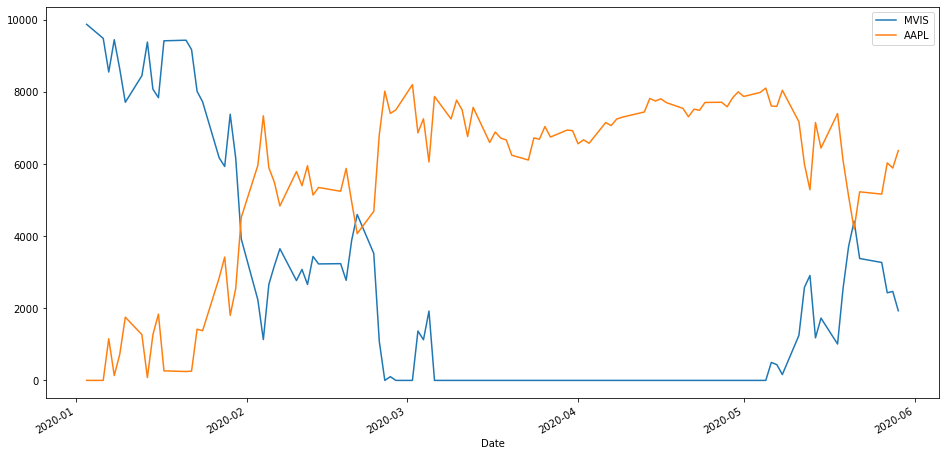

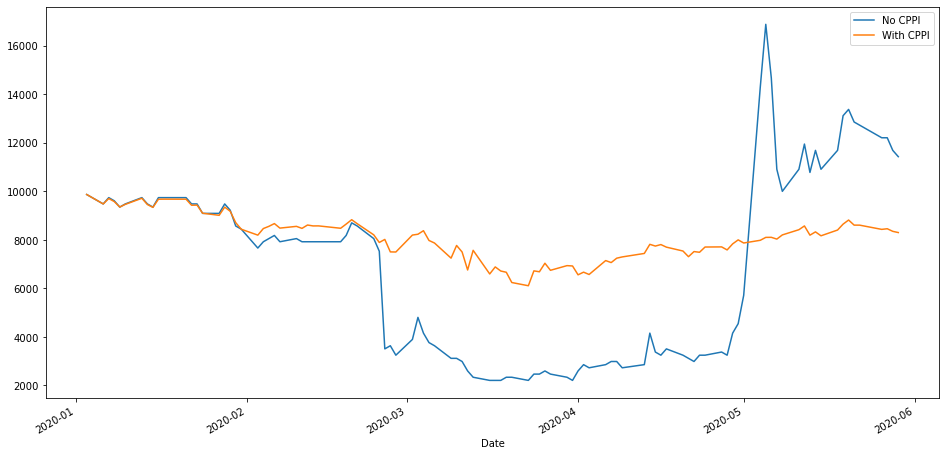

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas_datareader import data as web

stock_list = ['AAPL','MVIS'] #Define the stocks in your portfolio

#Importing stock data from Yahoo Finance!
my_stock = pd.DataFrame()
for element in stock_list:
    my_stock[element] = web.DataReader(element, data_source='yahoo', start = '01-01-2020', end = '31-05-2020')['Adj Close']
        
#Let's calculate value at risk for our portfolio for this time period (Q1) with confidence level of 99%

def portfolio_var(r,level=5):
    return round(-np.percentile(r,level,axis=0)*100,2)

#Remember that Var at a certain confidence gives the worst return from the remaining samples after eliminating the lowest % values below the confidence internal
#In our case for 99% confidence, the output is the worst return in 99% of the times.

my_stock_returns = my_stock.pct_change().dropna()
my_var_value = my_stock_returns.aggregate(portfolio_var)

risky_returns = my_stock_returns[['MVIS']]
safe_returns = my_stock_returns[['AAPL']]
#print(safe_returns.head())

#Create a risky and safe allocation of same size as their respective returns using reindex_like() function
risky_alloc = pd.DataFrame().reindex_like(risky_returns)
safe_alloc = pd.DataFrame().reindex_like(safe_returns)
account_history = pd.DataFrame().reindex_like(safe_returns)

#Use Var to define floor of your portfolio
#Absolute worst case considering a drop across all your portfolio stocks in the given time period

print("Worst case drop across portfolio is:", round(my_var_value.sum(),2),"% at 95% confidence")

#We can either take this as the floor for our portfolio or define our floor as a certain value above this.
#Let's treat our floor as 20%, i.e. F = 20%

#CPPI basic values definition

investment = 10000
my_floor = investment*0.8
my_M = 1/(my_var_value.sum()/100)

#Traditional CPPI
dates = risky_returns.index
date_index = len(dates) #Calculating the length of date index so you can iterate over it using For loop


for step in range(date_index):
    cushion = (investment - my_floor)/investment #Calculating cushion
    risky_w = my_M*cushion #Calculating the weight of the risky asset
    risky_w = np.minimum(risky_w,1) #Defining the weight such that it is less than 1 (100%)
    risky_w = np.maximum(risky_w,0) #Defining the weight such that it is at least 0 (weight should not go negative)
    safe_w = 1 - risky_w #Defining the weight of the stable asset
    risky_alloc.iloc[step] = (investment*risky_w)*(1+risky_returns.iloc[step]) #Allocation to the risky asset
    safe_alloc.iloc[step] = (investment*safe_w)*(1+safe_returns.iloc[step]) #Allocation to the safe asset
    investment = risky_alloc.iloc[step].sum()+safe_alloc.iloc[step].sum() #CPPI which is your investment to the next iteration
    account_history.iloc[step] = investment
    
account_history.columns = ['With CPPI']
#Plot the risky and safe allocations
axis1 = risky_alloc.plot(figsize = (16,8))
safe_alloc.plot(ax=axis1)

#Wealth without CPPI
risky_wealth = (10000)*(1+risky_returns).cumprod()
risky_wealth.columns = ['No CPPI']
axis2 = risky_wealth.plot(figsize=(16,8))
account_history.plot(ax=axis2)
